Libraries imported successfully!

First 5 rows of the dataset:


,date,price_usd_per_gallon
0,2025-08-25 00:00:00,3.272
1,2025-08-18 00:00:00,3.251
2,2025-08-11 00:00:00,3.243
3,2025-08-04 00:00:00,3.265
4,2025-07-28 00:00:00,3.247



Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1691 entries, 0 to 1690
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   date                  1691 non-null   object 
 1   price_usd_per_gallon  1691 non-null   float64
dtypes: float64(1), object(1)
memory usage: 26.6+ KB
Cleaned Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1691 entries, 1993-04-05 to 2025-08-25
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   price_usd_per_gallon  1691 non-null   float64
dtypes: float64(1)
memory usage: 26.4 KB

First 5 rows with date as index:


,price_usd_per_gallon
date,
1993-04-05,1.068
1993-04-12,1.079
1993-04-19,1.079
1993-04-26,1.086
1993-05-03,1.086


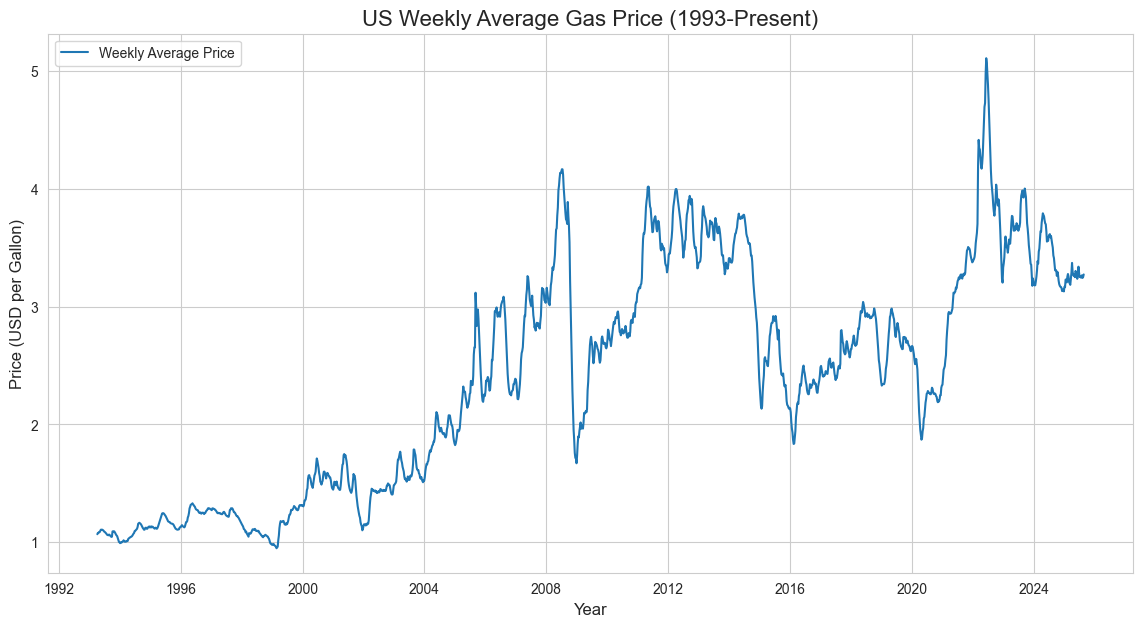

Yearly Average Prices (Last 5 Years):


C:\Users\sethn\AppData\Local\Temp\ipykernel_27060\1494178135.py:71: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  yearly_avg_df = df['price_usd_per_gallon'].resample('Y').mean()


date
2021-12-31    3.100327
2022-12-31    4.058538
2023-12-31    3.634596
2024-12-31    3.424396
2025-12-31    3.253118
Freq: YE-DEC, Name: price_usd_per_gallon, dtype: float64

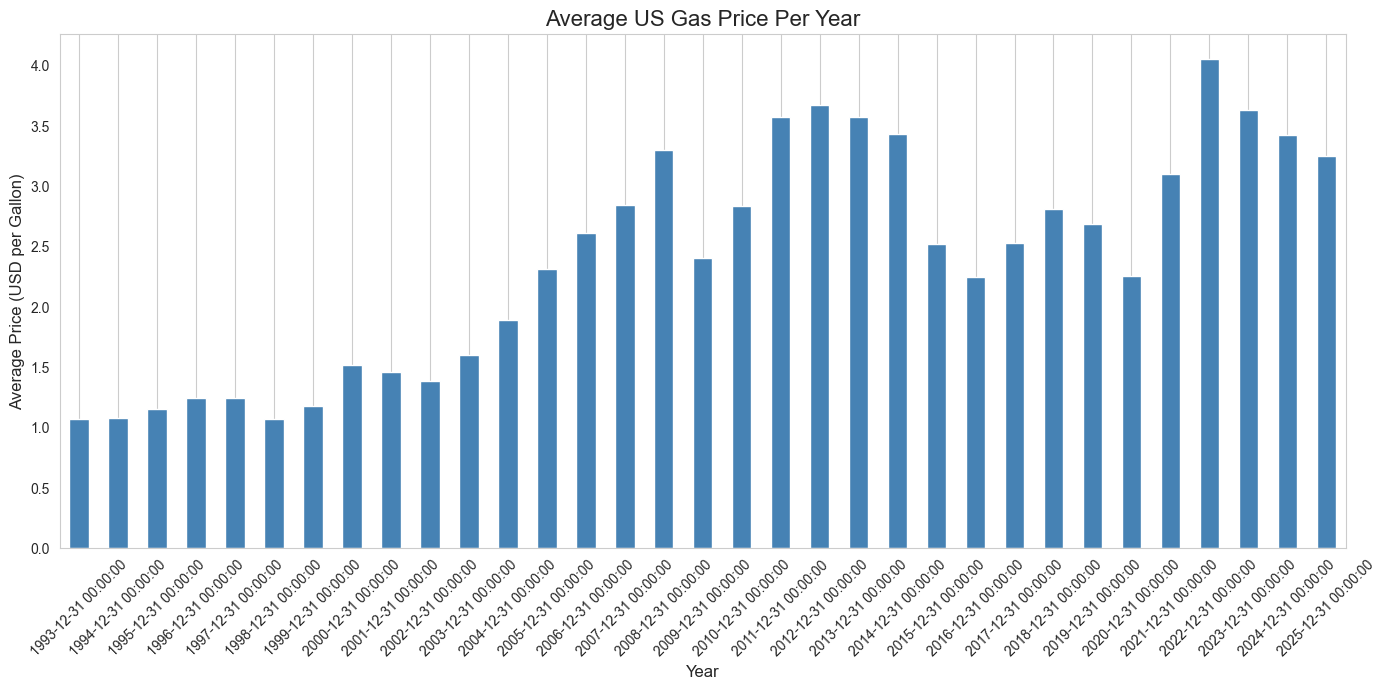

In [9]:
# Import necessary libraries
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

# Set a nice style for our plots
sns.set_style("whitegrid")

print("Libraries imported successfully!")

# --- Load the Data ---
db_connection = sqlite3.connect('gas_prices.db')
query = "SELECT * FROM weekly_prices"

# Use Pandas to read data directly from your SQL database
df = pd.read_sql_query(query, db_connection)

# --- Initial Data Inspection ---
# Display the first 5 rows of your data to make sure it loaded correctly
print("\nFirst 5 rows of the dataset:")
display(df.head())

# Display information about the columns and their data types
print("\nDataset Info:")
df.info()

# --- Data Cleaning and Preparation ---

# 1. Convert 'date' column to datetime objects
# The `to_datetime` function is smart enough to figure out the format.
df['date'] = pd.to_datetime(df['date'])

# 2. Set the 'date' column as the DataFrame index.
# This makes our data a true time-series.
df.set_index('date', inplace=True)

# 3. Sort the data by date, just in case it's not in order.
df.sort_index(inplace=True)

# --- Verify the changes ---
print("Cleaned Dataset Info:")
df.info()

print("\nFirst 5 rows with date as index:")
display(df.head())

# --- Visualize the Data ---

# Create a plot with a good size for viewing
plt.figure(figsize=(14, 7))

# Plot the 'price_usd_per_gallon' column.
# Since the date is our index, Pandas and Matplotlib know to use it for the x-axis.
plt.plot(df['price_usd_per_gallon'], label='Weekly Average Price')

# Add a title and labels to make the plot clear and professional
plt.title('US Weekly Average Gas Price (1993-Present)', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Price (USD per Gallon)', fontsize=12)
plt.legend()
plt.grid(True)

# Display the plot|
plt.show()

# --- Aggregate Data by Year ---

# 'resample' is a powerful Pandas function for time-series data.
# We're telling it to group our data by 'Y' (Year) and then calculate the mean() for each group.
yearly_avg_df = df['price_usd_per_gallon'].resample('Y').mean()

# Let's look at the calculated average for the last 5 years
print("Yearly Average Prices (Last 5 Years):")
display(yearly_avg_df.tail())

# --- Visualize Yearly Averages ---

plt.figure(figsize=(14, 7))

# Create a bar chart of the yearly average data
yearly_avg_df.plot(kind='bar', color='steelblue')

plt.title('Average US Gas Price Per Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Price (USD per Gallon)', fontsize=12)

# This part just makes the year labels on the x-axis readable
plt.xticks(rotation=45)
plt.grid(axis='y')

# Adjust layout to make sure everything fits without overlapping
plt.tight_layout()

plt.show()

In [10]:
# --- Prepare Data for Machine Learning ---

# We need to use our original weekly data, so let's make a copy to work with
ml_df = df.copy()

# 1. Create our "feature" (X): the price from the previous week.
# The .shift(1) function shifts all the data down by one period.
ml_df['previous_week_price'] = ml_df['price_usd_per_gallon'].shift(1)

# 2. Our "target" (y) is the current week's price, which is already in the 'price_usd_per_gallon' column.

# 3. Clean the data: The first row will have no 'previous_week_price' (since there's no data before it),
# so we drop that one row of missing data.
ml_df.dropna(inplace=True)


# --- Display the prepared data ---
print("Data prepared for Machine Learning (X=previous_week_price, y=price_usd_per_gallon):")
display(ml_df.head())

Data prepared for Machine Learning (X=previous_week_price, y=price_usd_per_gallon):


,price_usd_per_gallon,previous_week_price
date,,
1993-04-12,1.079,1.068
1993-04-19,1.079,1.079
1993-04-26,1.086,1.079
1993-05-03,1.086,1.086
1993-05-10,1.097,1.086


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import numpy as np

# --- Split Data into Training and Testing Sets ---

# X is our feature (the input)
X = ml_df[['previous_week_price']]
# y is our target (the output)
y = ml_df['price_usd_per_gallon']

# This function splits the data. test_size=0.2 means 20% of the data is for testing.
# random_state=42 ensures we get the same "random" split every time we run it.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {len(X_train)} rows")
print(f"Testing set size: {len(X_test)} rows")


# --- Create and Train the Model ---

# Create an instance of the Linear Regression model
model = LinearRegression()

# "Fit" the model to our training data. This is the "learning" step.
model.fit(X_train, y_train)

print("\nModel training complete!")

Training set size: 1352 rows
Testing set size: 338 rows

Model training complete!


Model has made predictions on the test data.

--- Model Evaluation ---
Mean Absolute Error (MAE): $0.0327
Root Mean Squared Error (RMSE): $0.0492

Plotting a sample of the results...


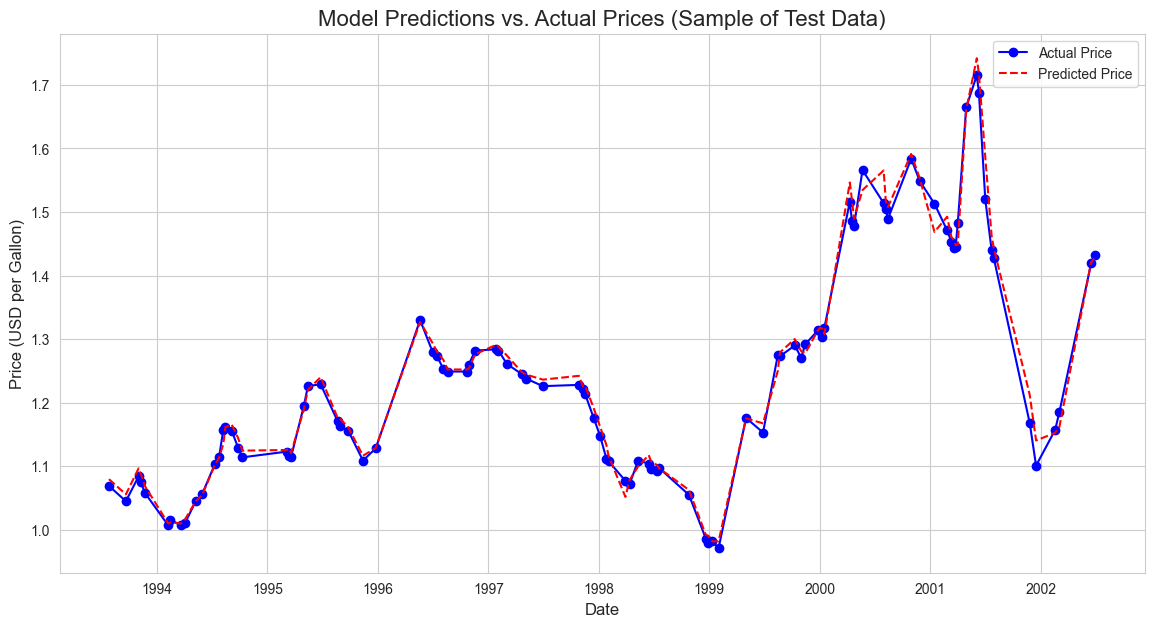

In [12]:
from sklearn import metrics
import numpy as np

# --- Make Predictions on the Test Data ---

# Use the trained model to predict prices for our test set (the "final exam")
predictions = model.predict(X_test)

print("Model has made predictions on the test data.")


# --- Evaluate the Model's Performance ---

# Let's compare the predictions to the actual values (y_test)
print("\n--- Model Evaluation ---")

# Mean Absolute Error (MAE): On average, how far off was our prediction in dollars?
mae = metrics.mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): ${mae:.4f}')

# Root Mean Squared Error (RMSE): Another common metric that penalizes larger errors more.
rmse = np.sqrt(metrics.mean_squared_error(y_test, predictions))
print(f'Root Mean Squared Error (RMSE): ${rmse:.4f}')


# --- Visualize the Predictions vs. Actual Prices ---

# We'll create a DataFrame to easily plot the actual vs. predicted values
results_df = pd.DataFrame({'Actual Price': y_test, 'Predicted Price': predictions})

# To make the plot chronological, we sort it by the original date index
results_df = results_df.sort_index()

print("\nPlotting a sample of the results...")

# Plotting just the first 100 results to keep the chart readable
plt.figure(figsize=(14, 7))
plt.plot(results_df['Actual Price'].head(100), label='Actual Price', color='blue', marker='o')
plt.plot(results_df['Predicted Price'].head(100), label='Predicted Price', color='red', linestyle='--')

plt.title('Model Predictions vs. Actual Prices (Sample of Test Data)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD per Gallon)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()